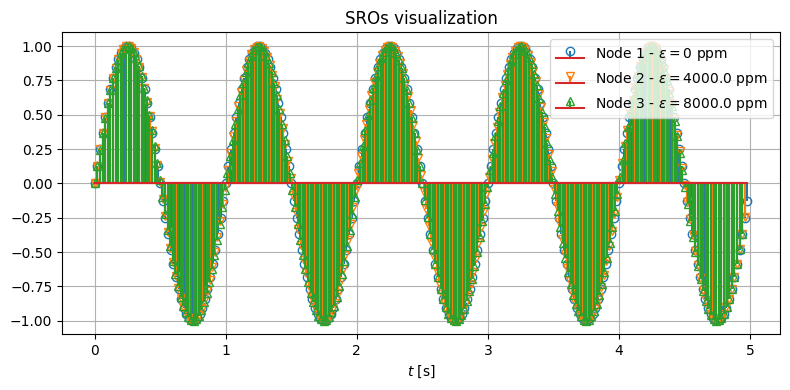

In [6]:
from pathlib import Path, PurePath
import sys
import numpy as np
import matplotlib
matplotlib.style.use('default')  # <-- for Jupyter: white figures background
# Find path to root folder
rootFolder = 'sounds-phd'
pathToRoot = Path().resolve()
while PurePath(pathToRoot).name != rootFolder:
    pathToRoot = pathToRoot.parent
sys.path.append(f'{pathToRoot}/01_algorithms/01_NR/02_distributed')
from danse_utilities.setup import apply_sro

fs = 50                   # sampling frequency [samples/s] (true sampling rate)
dur = 10                    # signal duration [s]
sroppm = 9025                 # SRO [ppm] 
f = 1
# fs = 16000                   # sampling frequency [samples/s] (true sampling rate)
# dur = 0.11                    # signal duration [s]
# sroppm = 50                 # SRO [ppm] 
# f = 1000

nSamples = int(fs * dur)        # total number of samples

t = np.arange(nSamples) / fs
nNodes = 3
x = np.zeros((len(t), nNodes))
for ii in range(nNodes):
    x[:, ii] = np.sin(2 * np.pi * f * t)

sros = [0, 4e3, 8e3] # [ppm]

sensorToNodeTags = np.array([1,2,3])
x_out, t_out = apply_sro(x, fs, sensorToNodeTags, sros, showSRO=True)

In [8]:
t
t_out

array([[0.        , 0.        , 0.        ],
       [0.02      , 0.01992032, 0.01984127],
       [0.04      , 0.03984064, 0.03968254],
       ...,
       [9.94      , 9.90039841, 9.86111111],
       [9.96      , 9.92031873, 9.88095238],
       [9.98      , 9.94023904, 9.90079365]])

In [59]:
# Flag-raising

frameLength = 1024 * 2  # samples
overlap = 0.5
blockLength = frameLength * overlap
nData = len(t)
nBlocks = int(np.ceil(nData / blockLength))  # number of data blocks in the entire batch of data

fs_out = fs * (1 + sroppm / 1e6)

trange = np.zeros(nBlocks)
flag = np.zeros(nBlocks)
for blkidx in range(nBlocks):

    lastSampleIdx_out = (blkidx + 1) * frameLength / 2
    lastSampleTime_out = lastSampleIdx_out / fs_out
    lastSampleIdx_in = np.argmin(np.abs(t - lastSampleTime_out))
    blockIndices_in = np.arange(lastSampleIdx_in - frameLength + 1, lastSampleIdx_in)

    blockIndices_in_clean = np.array([int(el) for el in blockIndices_in if el >= 0 and el < nData])
    blockIndices_out = np.arange(lastSampleIdx_out - frameLength + 1, lastSampleIdx_out)

    blockIndices_out_clean = np.array([int(el) for el in blockIndices_out if el >= 0 and el < nData])
    trange[blkidx] = t_out[blockIndices_out_clean[-1], 0] - t[blockIndices_in_clean[-1]]
    
    if blkidx > 0:
        flag[blkidx] = trange[blkidx] - trange[blkidx - 1] > 2 * np.finfo(float).eps    # <-- taking machine precision into account

if 0:
    import matplotlib.pyplot as plt
    %matplotlib widget
    plt.plot(trange, '.-')
    plt.plot(flag * np.amax(trange)) 

In [65]:
# SRO estimation / compensation implementation 
import scipy.signal as sig

# I) Get signals STFTs
winL = 1024
winOvlp = 0.5
X = sig.stft(x_out, nperseg=winL, noverlap=int(winOvlp*winL), axis=0)

# Loop over frames
for l in range(X.shape[-1]):
    
    